# **Lab 4. GenerativeDeepLearning**


### **Import libraries**

In [23]:
import numpy as np
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

from keras.datasets import fashion_mnist,mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU, Dropout
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers, regularizers, constraints
from keras.utils import plot_model, np_utils
from keras import backend as K
from numpy.random import randn, randint
from keras.engine import InputSpec, Layer
from scipy.stats import norm
from keras.preprocessing import image
import os

import time
import pickle
from PIL import Image

import tensorflow as tf

print("TF version: {}".format(tf.__version__))

TF version: 2.2.0


# **Generative Deep Learning**

Until now we have seen models that work with labelled data; now we move in an unsupervised setting: we have data $X$ without labels, and the goal is to learn some hidden or underlying structure of the data (e.g. in ML dimensionality reduction, ..).

More specifically, the goal of generative models is to take as input training samples from some distribution and learn a model that represents that distribution; once we have that model, we can use it to generate new data.


![alt text](https://i1.wp.com/dataisutopia.com/wp-content/uploads/2019/11/discriminative_generative.png?fit=500%2C322&ssl=1) 

We want to learn $P_{model}(x)$ similar to $P_{data}(x)$.

We will see three classes of models:

1.   **Autoencoders (AEs)**
2.   **Convolutional Autoencoders (CAEs)** 
3.   **Generative Adversarial Networks (GANs)**

## **4.1. Autoencoders**

An autoencoder is a neural network that is trained to attempt to copy its input to its output.<br>The network may be viewed as consisting of two parts: 

*   an encoder function $h = f(x)$
*   a decoder that produces a reconstruction $r = g(h)$


![alt text](https://miro.medium.com/max/600/1*nqzWupxC60iAH2dYrFT78Q.png)


Traditionally, autoencoders were used for dimensionality reduction or feature learning; recently, theoretical connections with latent variable models have brought autoencoders to the forefront of generative modeling.


Autoencoders learn a “compressed representation” of input automatically by first compressing the input (encoder) and decompressing it back (decoder) to match the original input.

The learning is aided by using distance function that quantifies the information loss that occurs from the lossy compression.



![alt text](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

### **Load MNIST dataset**


In [ ]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()# --fill here-- #
# load mnist dataset (tf.keras.datasets)
# (x_train, _), (x_test, _) = # --fill here-- #

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# convert data into float32 and normalize in range [0,1]
#x_train = # --fill here-- #
#x_test = # --fill here-- #
print(x_train.shape)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
# reshape data: reshape the images to be input to a Dense layers(e.g. (60000, 28, 28)-> (60000, 28*28))
#x_train = # --fill here-- #
#x_test = # --fill here-- #

x_train.shape, x_test.shape

(60000, 28, 28)
(60000, 784)


((60000, 784), (10000, 784))

### **Build a simple autoencoder**
You can create models in Keras in two ways: using sequential API or the functional API.
With the latter, you can declare each layer specifing the previous layer (that produces the input for the current layer) and finally build the model:
        
        e.g.  input_layer = tf.keras.layers.Input(shape=(n,))
              layer1 = tf.keras.layers.Dense(m)(input_layer)
              layer2 = tf.keras.layers.Dense(m)(layer1)
              model = tf.keras.models.Model(input_layer, layer2)

This API allow you to create models that have a lot more flexibility (e.g. you can define models where layers connect to any other layers). 

In [ ]:
# size of the encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# input layer
input_img = tf.keras.layers.Input(shape=(x_train.shape[1],))
# "encoded" is the encoded representation of the input
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = tf.keras.layers.Dense(x_train.shape[1], activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = tf.keras.models.Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = tf.keras.models.Model(input_img, encoded)

# create a input layer for an encoded (32-dimensional) input to be used by decoder
encoded_input = tf.keras.layers.Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

### **Compile the model**


In [ ]:
adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder.compile(optimizer=adam, loss='mse')

### **Train the model**


In [ ]:
history = autoencoder.fit(x_train, x_train, 
                #epochs=# --fill here-- # # in this case 30 epochs can be sufficient
                #batch_size=# --fill here-- #,
                #validation_data=(# --fill here-- #, # --fill here-- #)
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0715 - val_loss: 0.0411
Epoch 2/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0349 - val_loss: 0.0295
Epoch 3/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0266 - val_loss: 0.0232
Epoch 4/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0216 - val_loss: 0.0194
Epoch 5/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0182 - val_loss: 0.0165
Epoch 6/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0158 - val_loss: 0.0145
Epoch 7/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0141 - val_loss: 0.0131
Epoch 8/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0129 - val_loss: 0.0121
Epoch 9/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0121 - val_loss: 0.0115
Epoch 10/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0116 - val_loss: 0.0110

### **Plot training and validation loss values**


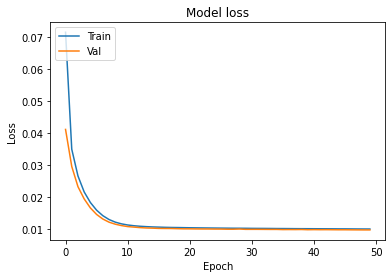

In [ ]:
def plot_hist(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

plot_hist(history)

### **Visualize some outputs of the decoder $r = g(h)$** 

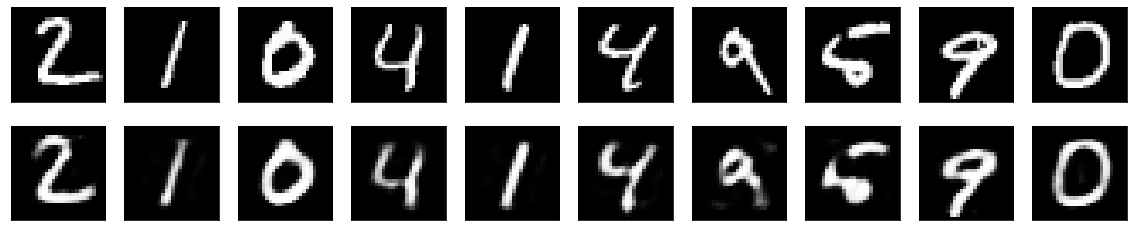

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10  # number of images to display
plt.figure(figsize=(20, 4))
for i in range(1,n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    #plt.imshow(# --fill here-- #,.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    #plt.imshow(# --fill here-- #,.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### **Visualize some outputs of the encoder $h = f(x)$** 

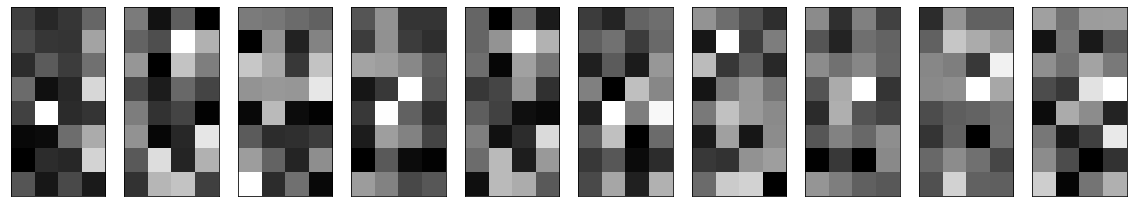

In [ ]:
encoded_imgs = encoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1,n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape(4, 8).T)
    # plt.imshow(# --fill here-- #.reshape(4, 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### **Try to use a regularizer (as L1) in the encoder. How does this affect the results? What can you observe?**

Induce sparsity, less validation loss value, reconstructed images less accurate

In [ ]:
## hint: Let's train this model for more epochs (with the added regularization the model is less likely to overfit and can be 
## trained longer).

encoding_dim = 32  

input_img = tf.keras.layers.Input(shape=(x_train.shape[1],))
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu',activity_regularizer=tf.keras.regularizers.l1(10e-5))(input_img)
decoded = tf.keras.layers.Dense(x_train.shape[1], activation='sigmoid')(encoded)
#input_img = # --fill here-- #
#encoded =# --fill here-- # ## hints Dense layer has the activity_regularizer parameter https://keras.io/api/layers/regularizers/
#decoded =# --fill here-- #

autoencoder = tf.keras.models.Model(input_img, decoded)
#autoencoder =# --fill here-- #

encoder = tf.keras.models.Model(input_img, encoded)
#encoder =# --fill here-- #

encoded_input = tf.keras.layers.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
#encoded_input =# --fill here-- #
#decoder_layer =# --fill here-- #

decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))
#decoder =# --fill here-- #

### **Compile the model**


In [ ]:
autoencoder.compile(optimizer=adam, loss='binary_crossentropy')
# --fill here-- #

### **Train the model**


In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))
# --fill here-- #


Epoch 1/30
235/235 [==============================] - 1s 4ms/step - loss: 0.2050 - val_loss: 0.1548
Epoch 2/30
235/235 [==============================] - 1s 3ms/step - loss: 0.1448 - val_loss: 0.1344
Epoch 3/30
235/235 [==============================] - 1s 3ms/step - loss: 0.1305 - val_loss: 0.1244
Epoch 4/30
235/235 [==============================] - 1s 3ms/step - loss: 0.1228 - val_loss: 0.1186
Epoch 5/30
235/235 [==============================] - 1s 3ms/step - loss: 0.1181 - val_loss: 0.1149
Epoch 6/30
235/235 [==============================] - 1s 3ms/step - loss: 0.1152 - val_loss: 0.1127
Epoch 7/30
235/235 [==============================] - 1s 3ms/step - loss: 0.1135 - val_loss: 0.1114
Epoch 8/30
235/235 [==============================] - 1s 3ms/step - loss: 0.1124 - val_loss: 0.1104
Epoch 9/30
235/235 [==============================] - 1s 3ms/step - loss: 0.1115 - val_loss: 0.1097
Epoch 10/30
235/235 [==============================] - 1s 3ms/step - loss: 0.1109 - val_loss: 0.1091

### **Visualize some outputs of the decoder $r = g(h)$** 

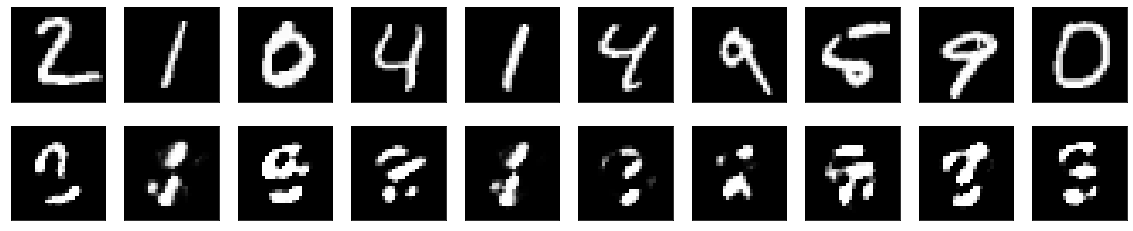

In [ ]:
decoded_imgs = decoder.predict(encoded_imgs)
#use the decoder to predict the images we have just encoded (encoded_imgs)
#decoded_imgs = --fill here-- #


n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n+1):
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## **4.2. Convolutional Autoencoders**
Convolutional Autoencoders combines Autoencoder with the convolutional operation: this operation allows Neural Networks to make a qualitative leap in the visual domain, due to its properties, and have made the Convolutional Neural Networks (CNNs) the state-of-the-art in most scenarios.

The key difference with CNNs is that them are trained end-to-end to learn filters and combine features with the aim of classifying their input (supervised learning); the CAEs are trained only to learn filters able to extract features that can be used to reconstruct the input.

### **Load MNIST dataset** 

In [ ]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
#(x_train, _), (x_test, _) = # --fill here-- #

x_train = x_train.astype('float32') / 255. 
x_test = x_test.astype('float32') / 255.
print(x_train.shape)
# convert to float and normalize in [0,1]
#x_train = # --fill here-- #
#x_test = # --fill here-- #

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 
# reshape data: reshape the images to be input to a Convolutional layer(e.g. (60000, 28, 28)-> (60000, 28,28,1))
#x_train = # --fill here-- #
#x_test = # --fill here-- # 
print(x_train.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


### **Build a Convolutional Autoencoder** 
Basically the CAE model, instead of Dense layers, has a set of convolutional and pooling layers (encoder) and convolutional and upsampling layers (decoder).


![alt text](https://www.researchgate.net/profile/Eli_David/publication/306081538/figure/fig3/AS:418518853013509@1476794078590/Illustration-of-convolutional-autoencoder-In-this-example-the-CAE-comprises-two.png)



In [ ]:
## Hint: in this example, you can use 3x3 kernels and few filters (such as 16 for the first layer and 8 for the others) for each layer, due to the difficulty of the problem


input_img = tf.keras.layers.Input(shape=(28, 28, 1))  

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
# x = # --fill here-- # # Conv layer with ReLU activation function
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
# x = # --fill here-- # # Max pooling layers with pool_size = (2,2)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = # --fill here-- # # Conv layer with ReLU activation function
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
# x = # --fill here-- # # Max pooling layers with pool_size = (2,2)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = # --fill here-- # # Conv layer with ReLU activation function

encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
# encoded = # --fill here-- # # Max pooling layers with pool_size = (2,2)


# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
# x = # --fill here-- # # Conv layer with ReLU activation function
x = tf.keras.layers.UpSampling2D((2, 2))(x)
# x = # --fill here-- # # Upsampling layer with size=(2,2)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = # --fill here-- # # Conv layer with ReLU activation function
x = tf.keras.layers.UpSampling2D((2, 2))(x)
# x = # --fill here-- # # Upsampling layer with size=(2,2)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
# x = # --fill here-- # # Conv layer with ReLU activation function
x = tf.keras.layers.UpSampling2D((2, 2))(x)
# x = # --fill here-- # # Upsampling layer with size=(2,2)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
# x = # --fill here-- # # Conv layer with sigmoid activation function (output image in range [0,1])

autoencoder = tf.keras.models.Model(input_img, decoded) 
# autoencoder = # --fill here-- # 

### **Compile the model** 


In [ ]:
autoencoder.compile(optimizer=adam, loss='binary_crossentropy')
# --fill here-- # 

### **Train the model** 


In [ ]:
epochs = 50
history = autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))
# history = # --fill here-- # 

Epoch 1/50
469/469 [==============================] - 3s 5ms/step - loss: 0.1768 - val_loss: 0.1365
Epoch 2/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1293 - val_loss: 0.1222
Epoch 3/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1201 - val_loss: 0.1159
Epoch 4/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1151 - val_loss: 0.1121
Epoch 5/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1117 - val_loss: 0.1091
Epoch 6/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1094 - val_loss: 0.1076
Epoch 7/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1077 - val_loss: 0.1066
Epoch 8/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1064 - val_loss: 0.1045
Epoch 9/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1053 - val_loss: 0.1035
Epoch 10/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1043 - val_loss: 0.1026

### **Plot training and validation loss values** 


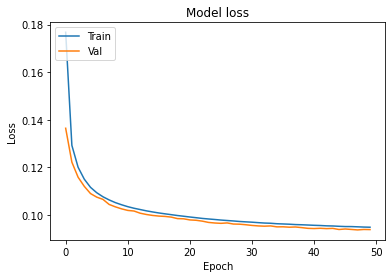

In [ ]:
plot_hist(history)
# --fill here-- # 

### **Visualize some outputs of the decoder $r = g(h)$**

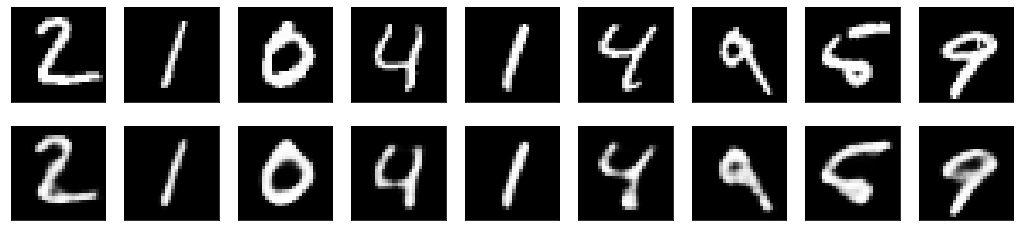

In [ ]:
decoded_imgs = autoencoder.predict(x_test)
# decoded_imgs = # --fill here-- # 

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

There are different interesting practical applications of autoencoders such as data denoising, anomaly detection and dimensionality reduction for data visualization.
 
### **Image denoising with Convolutional Autoencoders**

In this part of the lab we see the application to image denoising.
AGGIUNGERE COSE

![alt text](https://www.pyimagesearch.com/wp-content/uploads/2020/02/keras_denoising_autoencoder_overview.png)

### **Create noisy samples**

In [ ]:
# If you have just done the previous part (Convolutional Autoencoder), you've just load the dataset;
# otherwise you have to load data

noise_factor = 0.65
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.) # required to put all the values in [0,1]
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

### **Show some noisy samples**

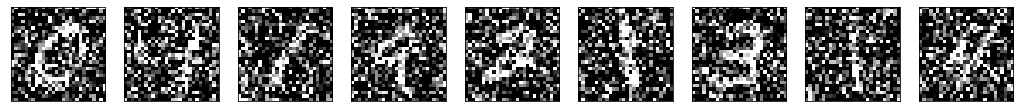

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### **Build a Convolutional Autoencoder**

In [ ]:
input_img = tf.keras.layers.Input(shape=(28, 28, 1))  
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img, decoded)

### **Compile the model**

In [ ]:
autoencoder.compile(optimizer=adam, loss='binary_crossentropy')

### **Train the model** 

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=150,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/150
469/469 [==============================] - 3s 7ms/step - loss: 0.1692 - val_loss: 0.1367
Epoch 2/150
469/469 [==============================] - 3s 6ms/step - loss: 0.1340 - val_loss: 0.1297
Epoch 3/150
469/469 [==============================] - 3s 6ms/step - loss: 0.1287 - val_loss: 0.1256
Epoch 4/150
469/469 [==============================] - 3s 6ms/step - loss: 0.1260 - val_loss: 0.1233
Epoch 5/150
469/469 [==============================] - 3s 6ms/step - loss: 0.1240 - val_loss: 0.1218
Epoch 6/150
469/469 [==============================] - 3s 6ms/step - loss: 0.1225 - val_loss: 0.1206
Epoch 7/150
469/469 [==============================] - 3s 6ms/step - loss: 0.1213 - val_loss: 0.1196
Epoch 8/150
469/469 [==============================] - 3s 6ms/step - loss: 0.1204 - val_loss: 0.1190
Epoch 9/150
469/469 [==============================] - 3s 6ms/step - loss: 0.1197 - val_loss: 0.1182
Epoch 10/150
469/469 [==============================] - 3s 6ms/step - loss: 0.1190 - val_lo

### **Visulize reconstructed (denoised) images** 

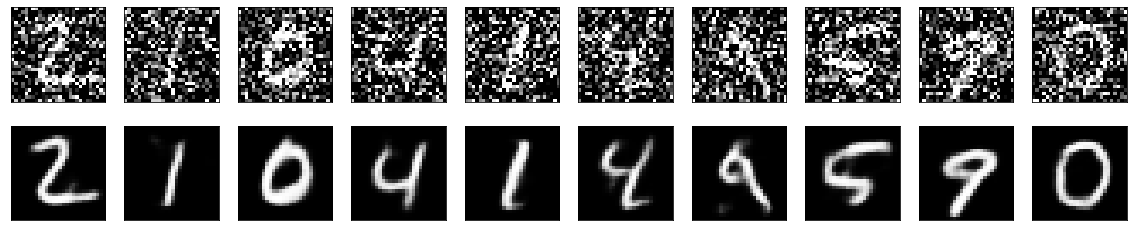

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### [OPTIONAL] Try to play with the noise_factor value: is there a threshold from which is not possible to reconstruct the image?

### How does the increase of the noise_factor value affect the number of epochs required in the training process?

In [ ]:
 # --fill here-- # [optional]

## **4.3. Generative Adversarial Networks**

In this part we will build a model able to generate new images using a **Deep Convolutional Generative Adversarial Network (DCGAN)**.

At https://arxiv.org/pdf/1511.06434.pdf you can find the DCGAN paper: this latter has lot of useful suggestions in terms of settings about the architecture, the optimizers and the hyperparameters to use.

![picture](https://drive.google.com/uc?id=1BEXEPdR-cwj84MbbsDGlQQgUzFd30KRe)

### **Load fashion-MNIST dataset** 

In this part, we will use the fashion-MNIST dataset, that cointains MNIST-like fashion product images (https://github.com/zalandoresearch/), to train the Generator and the Discriminator; after training, the Generator will be able to generate images that resembles the original fashion-MNIST data.

In [103]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# expand_dims allow to change the shape from (60000,28,28) to (60000,28,28,1)
X_train = np.expand_dims(X_train, axis = -1)
X_test = np.expand_dims(X_test, axis = -1)
# np.expand_dims allow to change the shape from (60000,28,28) to (60000,28,28,1)
# X_train = #--fill here--#
# X_test = #--fill here--#
print('X_train, y_train shape:', X_train.shape, y_train.shape, '\nX_test shape, y_test shape:', X_test.shape, y_test.shape)

X_train, y_train shape: (60000, 28, 28, 1) (60000,) 
X_test shape, y_test shape: (10000, 28, 28, 1) (10000,)


### **Visualize some samples**

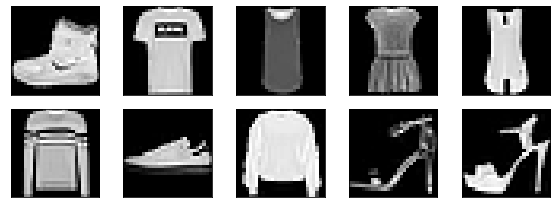

In [104]:
fig = plt.figure(figsize=(8,3))
for i in range(0, 10):
    plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(np.squeeze(X_train[i]),cmap='gray')
    
plt.tight_layout()

### **Preprocess data**


In [105]:
num_classes = 10

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

# the generator is using tanh activation in the last layer, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_train / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)


# convert class vectors to binary class matrices (you can use np_utils.to_categorical function of Keras.utils)
# y_train = #--fill here--#
# y_test = #--fill here--#

# the generator is using tanh activation in the last layer, for which we need to preprocess 
# the image data into the range between -1 and 1.

# X_train = np.float32(X_train)
# X_train = #--fill here--#
# clip in range [-1, 1] 
# X_train = #--fill here--#

# X_test = np.float32(X_test)
# X_test = #--fill here--#
# clip in range [-1, 1] 
# X_test = #--fill here--#

print('y_train reshape:', y_train.shape)
print('y_test reshape:', y_test.shape)

y_train reshape: (60000, 10)
y_test reshape: (10000, 10)


### **Define the Generator**

The Generator takes as input random noise (low dimensionality, e.g. 100) and produce an image (high dimensionality, e.g. 32 x 32 x 3): in order to perform the upsampling operation we can use the transposed convolution (Conv2DTranspose in Keras). 

The first layer of the Generator is a Dense layer that takes random noise as input (of dimension latent_dim) and upsample it through layers in order to obtain the size of the image (in this case 28x28x1).

After each Conv2DTranspose layer we can add a BatchNormalization layer (that helps during training) and a LeakyRelu activation layer.
The output layer uses tanh activation in order to output an image in [-1,1].

In [106]:
def gen(latent_dim):
    rn = initializers.RandomNormal(stddev=0.02)
    model = Sequential()

    # 7x7x112 
    model.add(Dense(7*7*112, input_shape=(latent_dim,), kernel_initializer=rn)) 
    model.add(Reshape((7, 7, 112)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    # 14x14x56 
    model.add(Conv2DTranspose(56, kernel_size=5, strides=2, padding='same',kernel_initializer=rn))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    # 28x28x1
    model.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', activation='tanh',kernel_initializer=rn))

    # 14x14x56
    # model.add(#--fill here--#) # transposed convolution (use 5x5 kernels and stride=2) 
    # model.add(#--fill here--#) # batch normalization
    # model.add(#--fill here--#) # Leaky ReLU

    # 28x28x1
    # model.add(#--fill here--#) # transposed convolution (use 5x5 kernels and stride=2 with tanh activation)
    return model

In [107]:
latent_dim = 100
generator = gen(latent_dim)
generator.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 5488)              554288    
_________________________________________________________________
reshape_6 (Reshape)          (None, 7, 7, 112)         0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 7, 7, 112)         448       
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 7, 7, 112)         0         
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 14, 14, 56)        156856    
_________________________________________________________________
batch_normalization_17 (Batc (None, 14, 14, 56)        224       
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 14, 14, 56)      

### **Plot samples generated by the Generator before training**

In [108]:
# generate points in latent space as input for the Generator
def generate_latent_points(latent_dim, n_samples): 
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape((n_samples, latent_dim)) 	# reshape into a batch of inputs for the network
    return x_input
  
# using the function predict() generate num_samples samples and plot it using plt.imshow
def plot_generated_samples(generator,num_samples,title=""):
    x_fake = generator.predict(generate_latent_points(latent_dim, num_samples))
    fig = plt.figure(figsize=(7,7))
    for k in range(num_samples):
        plt.subplot(np.sqrt(num_samples), np.sqrt(num_samples), k + 1, xticks=[], yticks=[])
        aux = np.squeeze(x_fake[k])
        plt.imshow(((aux + 1)* 127).astype(np.uint8),cmap='gray')
    fig.suptitle(title)
    plt.show()


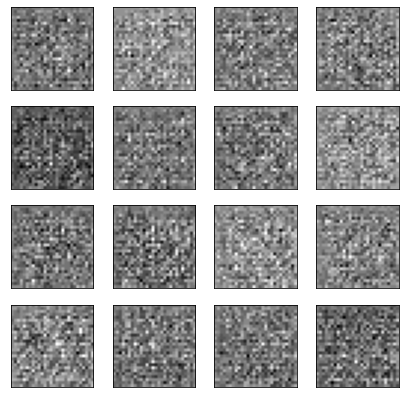

In [109]:
plot_generated_samples(generator,16)

### **Define the Discriminator**

The Discriminator is a Convolutional Neural Network that distinguish between real and generated samples (basically it is a binary classification problem). 

In [110]:
def dis(input_shape):

    rn = initializers.RandomNormal(stddev=0.02)
    model = Sequential()

    # 14x14x56
    model.add(Conv2D(56, kernel_size=5, strides=2, padding='same',input_shape=(input_shape), kernel_initializer=rn))
    model.add(LeakyReLU(0.2))

    # 7x7x112
    model.add(Conv2D(112, kernel_size=5, strides=2, padding='same',kernel_initializer=rn))#,kernel_initializer=rn
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    # 4x4x224
    model.add(Conv2D(224, kernel_size=5, strides=2, padding='same',kernel_initializer=rn))#,kernel_initializer=rn
    model.add(LeakyReLU(0.2))

    model.add(Flatten()) 
    model.add(Dense(1, activation='sigmoid'))

    # 14x14x56
    # model.add(#--fill here--#) # Convolutional layer (5x5 kernels and stride=2)
    # model.add(#--fill here--#) # LeakyReLU

    # 7x7x112
    # model.add(#--fill here--#) # Convolutional layer (5x5 kernels and stride=2)
    # model.add(#--fill here--#)# Batch normalization
    # model.add(#--fill here--#)# LeakyReLU

    # 4x4x224
    # model.add(#--fill here--#)#  Convolutional layer (5x5 kernels and stride=2)
    # model.add(#--fill here--#) # LeakyReLU

    # Flatten layer
    # model.add(#--fill here--#) 
    # Output Dense layer (binary)
    # model.add(#--fill here--#)

    return model

In [111]:
input_shape = X_train.shape[1:]
print(input_shape)
discriminator = dis(input_shape)
discriminator.summary()

(28, 28, 1)
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 14, 14, 56)        1456      
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 14, 14, 56)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 112)         156912    
_________________________________________________________________
batch_normalization_18 (Batc (None, 7, 7, 112)         448       
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 7, 7, 112)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 4, 4, 224)         627424    
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 4, 4,

### **Classify some generated samples before training**

In [112]:
num_samples = 3
latend_dim = 100
generated_samples = generator.predict(generate_latent_points(latent_dim, num_samples))
print(generated_samples.shape)
decision = discriminator.predict(generated_samples)
print(decision)

# num_samples = 3
# latend_dim = 100

# z = #--fill here--#
# generated_samples = #--fill here--#
# print(generated_samples.shape)
# decision = #--fill here--#
# print(decision)

(3, 28, 28, 1)
[[0.4999659]
 [0.5000027]
 [0.5000849]]


### **Define the GAN model**

In order to create the GAN model in Keras you should create a Model that incorporate both the Generator and the Discriminator.

In this lab we use Adam optimizer, as suggested in the DCGAN paper, but you can change it (e.g. SGD, RMSprop, etc..) and the hyperparameters (learning rate, momentum, etc..) to see how it affects the training phase.  

In [113]:
def GAN(discriminator_lr, generator_lr, discriminator, generator):
	
    discriminator.compile(Adam(lr=discriminator_lr, beta_1=0.5), loss='binary_crossentropy',metrics=['binary_accuracy'])
    discriminator.trainable = False

    z = Input(shape=(latent_dim,))
    hidden = generator(z)
    output = discriminator(hidden)
    model = Model(inputs=z, outputs=output)

    model.compile(Adam(lr=generator_lr, beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])
    return model
	

In [114]:
discriminator_lr=0.0002
generator_lr = 0.0002
gan = GAN(discriminator_lr,generator_lr,discriminator,generator)
gan.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_11 (Sequential)   (None, 28, 28, 1)         713217    
_________________________________________________________________
sequential_12 (Sequential)   (None, 1)                 789825    
Total params: 1,503,042
Trainable params: 712,881
Non-trainable params: 790,161
_________________________________________________________________


### **Utils function to plot the losses**


In [115]:
def plot_loss(d_loss,g_loss, dim):
    plt.close()
    plt.figure(figsize=dim)
    plt.plot(d_loss)
    plt.plot(g_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Iteration')
    plt.legend(['Discriminator', 'Adversarial'], loc='upper right')
    plt.show()

#def save_model():

### **Training**

In order to train the model, firstly set the batch_size and how many iterations the training loop will do; then you should complete the code following this picture (it is taken from the original GAN paper https://arxiv.org/abs/1406.2661) 



![alt text](https://cdn.analyticsvidhya.com/wp-content/uploads/2017/06/11000810/g3.png)




You can use the train_on_batch function provides by Keras (https://keras.io/api/models/model_training_apis/#trainonbatch-method)

In [116]:
batch_size = 128
iterations = 1400
k = 1

# Label smoothing (label from 1 to 0.9: it helps during training)
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
g_loss = []

init_time = time.time()

for i in range(0, iterations + 1):
    start_time = time.time()

    for _ in range(k):

        # Sample minibatch of m noise samples from noise prior pg(z)
        z = generate_latent_points(latent_dim, batch_size)
        X_fake = generator.predict_on_batch(z)

        # Sample minibatch of m examples from data generating distribution pdata(x)
        index = np.random.choice(X_train.shape[0], batch_size, replace=False)  
        X_batch = X_train[index]

        # Update the Discriminator by ascending its stochastic gradient
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
        #print("d_fake",d_loss_fake)
        d_loss_real = discriminator.train_on_batch(x=X_batch, y=real * (1 - smooth))
        #print("d_real",d_loss_real)

        # Discriminator loss
        d_loss_batch = d_loss_real[0] + d_loss_fake[0]

    # Sample minibatch of m noisse samples from noise prior pg(z)
    z = generate_latent_points(latent_dim, batch_size)

    # Update the Generator by ascending its stochastic gradient
    g_loss_batch = gan.train_on_batch(x=z, y=real)
    #print("g_loss",g_loss_batch)

    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])    


    if i % 200 == 0:
        plot_generated_samples(generator,36)
        plot_loss(d_loss, g_loss, (6,4))    
        print('iteration = %d/%d, d_loss=%.3f, g_loss=%.3f' % (i + 1, iterations, d_loss[-1], g_loss[-1]), 100*' ')
        print("%s minutes per 10000 iterations ---\n\n" % ((time.time()-start_time)/60))


print("\n\n--- %s total minutes training time ---\n\n" % ((time.time()-init_time)/60))

Output hidden; open in https://colab.research.google.com to view.

### **Plot samples and the losses after training**

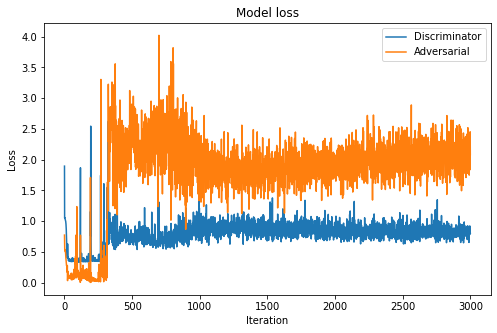

In [117]:
plot_loss(d_loss, g_loss, (8,5)) 

In [118]:
def plot_real_samples(num_samples,title=""):
    fig=plt.figure(figsize=(7,7))

    for k in range(num_samples):
        plt.subplot(np.sqrt(num_samples), np.sqrt(num_samples), k + 1, xticks=[], yticks=[])
        aux = np.squeeze(X_train[k])
        plt.imshow(((aux + 1)* 127).astype(np.uint8),cmap='gray')

    fig.suptitle(title)
    plt.show()

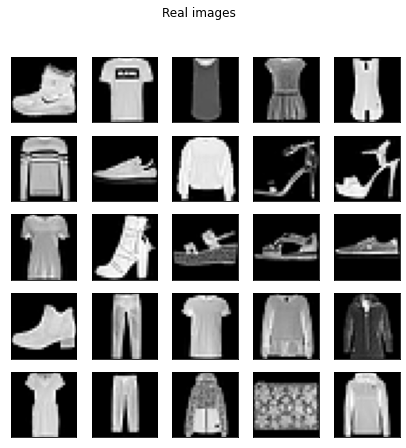

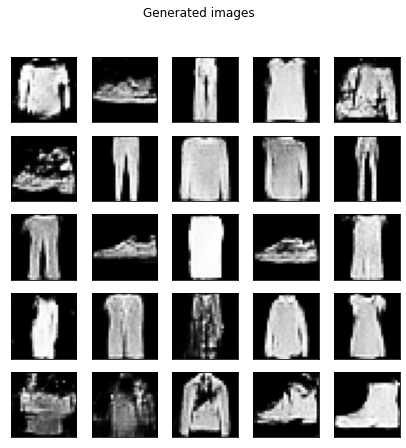

In [119]:
plot_real_samples(25,"Real images")
plot_generated_samples(generator,25,"Generated images")

# **Try with your own dataset**

1.    Find a dataset (possibly with lot of samples): if your data do not fit the RAM memory you can use a Data Generator that load data on the fly (here you can find an example https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly) or alternatively the image_dataset_from_directory function provided by Keras (https://keras.io/api/preprocessing/image/)

2.    Preprocess your data: convert each image to have the same dimension in range [-1,1] (the last layer of the Generator is tanh activation layer)

3.    Create the GAN model: build a Generator and a Discriminator in a mirror way (~ same number of convolutional layers) 

4.    Train your model: if something goes wrong, such as the losses saturates to zero or to big values and the Generator generates "garbage" images you can try to
  * adjust the learning rate of the Generator and of the Discriminator
  * change the architectures of the models (deeper with more complex problem)
  * change the hyperparameters *k* (more step of the Discriminator per each Generator step or the opposite)



